In [207]:
%pip install memory-profiler
%pip install timeout_decorator
%pip install networkx

DEPRECATION: pytorch-lightning 1.5.4 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: pytorch-lightning 1.5.4 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 

In [41]:
import pandas as pd
import numpy as np
from math import ceil
import networkx as nx
from timeout_decorator import timeout
from queue import PriorityQueue
from itertools import combinations
import matplotlib.pyplot as plt
import time
import tracemalloc
import os
import ast

In [42]:
#Determinando tempo máximo de 3min
MAX_TIME_SEG = 1800

### Criando funções auxiliares

#### Criando dataset com o nome dos arquivos e ordenando em ordem crescente de acordo com o tamanho dos nós

In [43]:
caminho_arquivo = 'datasets_limiar.txt'
df_dados_dataset = pd.read_csv(caminho_arquivo, delimiter='\t')

# Ordenando pelo tamanho dos nós
df_dados_dataset  = df_dados_dataset .sort_values(by='Nós')
print(df_dados_dataset )

     Dataset    Nós               Limiar
0      eil51     51                  426
1   berlin52     52                 7542
2       st70     70                  675
3      eil76     76                  538
4       pr76     76               108159
..       ...    ...                  ...
73   rl11849  11849      [920847,923368]
74  usa13509  13509  [19947008,19982889]
75  brd14051  14051      [468942,469445]
76    d15112  15112    [1564590,1573152]
77    d18512  18512      [644650,645488]

[78 rows x 3 columns]


#### Função para calcular a distância euclidiana

In [44]:
def distancia_euclidiana(pontos):
    np.array(pontos)
    arestas_euclidiana = []
    tamanho_pontos = len(pontos)

    for i in range(tamanho_pontos):
        for j in range(i+1, tamanho_pontos):
            # Distância Euclidiana
            ponto_i = np.array(pontos[i])
            ponto_j = np.array(pontos[j])
            distancia_euclidiana = np.linalg.norm(ponto_i - ponto_j)
            arestas_euclidiana.append((i, j, distancia_euclidiana))

    return arestas_euclidiana

Teste:

In [45]:
pontos = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
arestas_euclidiana = distancia_euclidiana(pontos)

for aresta in arestas_euclidiana:
    print(f'Pontos {aresta[0]} e {aresta[1]}: Distância Euclidiana = {aresta[2]}')

Pontos 0 e 1: Distância Euclidiana = 1.4142135623730951
Pontos 0 e 2: Distância Euclidiana = 2.8284271247461903
Pontos 0 e 3: Distância Euclidiana = 4.242640687119285
Pontos 1 e 2: Distância Euclidiana = 1.4142135623730951
Pontos 1 e 3: Distância Euclidiana = 2.8284271247461903
Pontos 2 e 3: Distância Euclidiana = 1.4142135623730951


#### Criando função extrair informações dos datasets

In [46]:
def dataset_info(idx_dataset, df_dados_dataset):
    name_dataset = df_dados_dataset.loc[idx_dataset, 'Dataset']
    tsp_file_path = "datasets/" + name_dataset + ".tsp"
    # Lendo o arquivo
    with open(tsp_file_path, 'r') as file:
        lines = file.readlines()

    # Encontrando a seção NODE_COORD_SECTION
    coord_section_index = lines.index('NODE_COORD_SECTION\n')

    # Criando um grafo direcionado
    G = nx.Graph()

    # Adicionando nós e coordenadas ao grafo
    for line in lines[coord_section_index + 1:]:
        # Ignorar a linha EOF
        if line.strip().lower() == 'eof':
            break

        node_info = line.split()

        if len(node_info) >= 3:
            node_id = int(node_info[0])
            x_coord = float(node_info[1])
            y_coord = float(node_info[2])
            G.add_node(node_id, pos=(x_coord, y_coord))
    
    # Extrair apenas as coordenadas
    cordenadas = [pos for _, pos in G.nodes(data='pos')]
            
    numero_de_nos = int(df_dados_dataset.loc[idx_dataset, 'Nós'])

    if '[' in df_dados_dataset.loc[idx_dataset, 'Limiar']:
        # Avaliar a string como uma lista
        lista_valores = ast.literal_eval(df_dados_dataset.loc[idx_dataset, 'Limiar'])
        
        # Obter o primeiro valor
        primeiro_valor = lista_valores[0]
        limiar = primeiro_valor

    else:
        # Se não for uma lista, converter para inteiro diretamente
        limiar = int(df_dados_dataset.loc[idx_dataset, 'Limiar'])

    
    return cordenadas, numero_de_nos, limiar, name_dataset

Teste:

In [47]:
idx_dataset = 0
cordenadas, numero_de_nos, limiar,  name_dataset = dataset_info(idx_dataset, df_dados_dataset)

print("Numero_de_nos: ", numero_de_nos)
print("Limiar: ", limiar)

print("Cordenadas:")
print(cordenadas)


Numero_de_nos:  51
Limiar:  426
Cordenadas:
[(37.0, 52.0), (49.0, 49.0), (52.0, 64.0), (20.0, 26.0), (40.0, 30.0), (21.0, 47.0), (17.0, 63.0), (31.0, 62.0), (52.0, 33.0), (51.0, 21.0), (42.0, 41.0), (31.0, 32.0), (5.0, 25.0), (12.0, 42.0), (36.0, 16.0), (52.0, 41.0), (27.0, 23.0), (17.0, 33.0), (13.0, 13.0), (57.0, 58.0), (62.0, 42.0), (42.0, 57.0), (16.0, 57.0), (8.0, 52.0), (7.0, 38.0), (27.0, 68.0), (30.0, 48.0), (43.0, 67.0), (58.0, 48.0), (58.0, 27.0), (37.0, 69.0), (38.0, 46.0), (46.0, 10.0), (61.0, 33.0), (62.0, 63.0), (63.0, 69.0), (32.0, 22.0), (45.0, 35.0), (59.0, 15.0), (5.0, 6.0), (10.0, 17.0), (21.0, 10.0), (5.0, 64.0), (30.0, 15.0), (39.0, 10.0), (32.0, 39.0), (25.0, 32.0), (25.0, 55.0), (48.0, 28.0), (56.0, 37.0), (30.0, 40.0)]


### Implementando algoritmos para solucionar o problema do caxeiro viajante

#### Branch and bound (Solução ótima)

In [48]:
class Node:
    def __init__(self, bound, nivel, custo, solucao):
        # 'bound': Limite associado ao nó na árvore do Branch and Bound.
        self.bound = bound
        # 'nivel': Nível na árvore em que o nó está localizado.
        self.nivel = nivel
        # 'custo': Custo associado ao nó (custo acumulado até o nó atual).
        self.custo = custo
        # 'solucao': Solução parcial associada ao nó.
        self.solucao = solucao

    # Método para comparar dois nós com base em seus limites (bound).
    # Esse método é utilizado para determinar a ordem de prioridade em uma fila de prioridade.
    def __lt__(self, outro):
        return self.bound < outro.bound


In [49]:
def bound(G, nodes):
    # Inicializando a estimativa total
    estimativa = 0
    
    size_nodes = len(nodes)
    # Convertendo a lista de vértices em listas de arestas
    edges = [(nodes[i], nodes[i+1]) for i in range(size_nodes-1)]
    
    # Calculando a estimativa com base nas arestas
    for (u, v) in edges:
        # Somando o dobro do peso da aresta ao custo total
        estimativa += (2 * G[u][v]['weight'])
    
   
    # Iterando sobre os vértices do grafo
    for u in G.nodes():          
        # Filtrando as arestas que incidem no vértice 'u'
        arestas_u = list(filter(lambda x: x[0] == u or x[1] == u, edges))
        
        size_arestas_u = len(arestas_u)
        # Verificando se 'u' tem menos de duas arestas incidentes
        if size_arestas_u < 2:
            # Obtendo os dados das arestas incidentes a 'u' e ordenando por peso
            dados_u = list(G.edges(u, data=True))
            dados_u = sorted(dados_u, key=lambda x: x[2]['weight'])
            w1, w2 = dados_u[0][2]['weight'], dados_u[1][2]['weight']
            
            # Caso 'u' não tenha arestas incidentes, adicionamos os dois menores pesos
            if size_arestas_u == 0:
                estimativa += w1
                estimativa += w2
            
            # Caso 'u' tenha uma aresta incidente, adicionamos o menor peso necessário
            elif size_arestas_u == 1:
                u, v = arestas_u[0]
                peso_necessario = G[u][v]['weight']
                estimativa += w1 if w1 < peso_necessario else w2
    
    # Arredondando para cima e retornando a estimativa dividida por 2
    output = ceil(estimativa / 2)
    return output

In [50]:
@timeout(MAX_TIME_SEG)
def branch_and_bound(grafo):
    
    tracemalloc.start()  # Inicia o rastreamento de alocação de memória
    G = grafo.copy()

    # Criando o nó raiz da árvore do Branch and Bound
    raiz = Node(bound(G, []), 1, 0, [0])
    
    # Inicializando a fila de prioridade com o nó raiz
    fila_prioridade = PriorityQueue()
    fila_prioridade.put(raiz)

    # Inicializando variáveis para armazenar a melhor solução encontrada
    melhor_solucao = np.inf
    solucao_encontrada = []
    
    # Percorrendo a fila de prioridade
    while not fila_prioridade.empty():

        # Obtendo o próximo nó da fila de prioridade
        no = fila_prioridade.get()

        # Verificando se o nó atual é uma folha da árvore
        if no.nivel == G.number_of_nodes():
            # Calculando o custo total da solução encontrada
            custo_total = no.custo + G[no.solucao[-1]][0]['weight']
            
            # Atualizando a melhor solução, se aplicável
            if custo_total < melhor_solucao:
                melhor_solucao = custo_total
                solucao_encontrada = no.solucao + [0]
        elif no.bound < melhor_solucao and no.nivel < G.number_of_nodes():
            v = no.solucao[-1]
            # Explorando os nós filhos do nó atual
            for k in range(G.number_of_nodes()):
                if k not in no.solucao and G.has_edge(v, k):
                    nova_solucao = no.solucao + [k]
                    estimativa = bound(G, nova_solucao)
                    # Verificando se a estimativa é melhor do que a melhor solução conhecida
                    if estimativa < melhor_solucao:
                        novo_custo = no.custo + G[v][k]['weight']
                        # Adicionando o novo nó à fila de prioridade
                        fila_prioridade.put(Node(estimativa, no.nivel+1, novo_custo, nova_solucao))
    # Mede o pico de uso de memória durante a execução da função e
    # converte o valor para megabytes para facilitar a leitura. 

    _ , peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()  # Interrompe o rastreamento de alocação de memória

    espaco_gasto_mb = peak / (1024 ** 2)  # Converte bytes para megabytes

    # Retornando a melhor solução encontrada, o custo, o tempo de execução e se o tempo limite foi excedido
    return solucao_encontrada, melhor_solucao, espaco_gasto_mb


Teste:

In [51]:
#idx_dataset = 0
#cordenadas, numero_de_nos, limiar = dataset_info(idx_dataset, df_dados_dataset)

#arestas_euclidiana = distancia_euclidiana(cordenadas)
#G = nx.Graph()
#G.add_weighted_edges_from(arestas_euclidiana)
#_, comprimento = branch_and_bound(G)

#print("Valor esperado: ", limiar )
#print("Valor obtido: ",comprimento )



#### Christofides (1.5 aproximado)

In [52]:
@timeout(MAX_TIME_SEG)
def christofides(grafo):
    tracemalloc.start()  # Inicia o rastreamento de alocação de memória
    
    G = grafo.copy()
    # Encontrando a árvore geradora mínima do grafo
    AGM = nx.minimum_spanning_tree(G)

    # Criando o conjunto de vértices com grau ímpar e construindo um subgrafo induzido
    vertices_grau_impar = [vertice for vertice in AGM.nodes() if AGM.degree(vertice) % 2 == 1]
    grafo_induzido = G.subgraph(vertices_grau_impar)

    # Invertendo o peso das arestas para calcular o emparelhamento perfeito de peso mínimo
    for u, v in grafo_induzido.edges():
        grafo_induzido[u][v]['weight'] *= -1

    # Encontrando o emparelhamento perfeito de peso mínimo e revertendo os pesos
    emparelhamento_min_peso = nx.max_weight_matching(grafo_induzido, maxcardinality=True)

    # Criando um subgrafo induzido com as arestas do emparelhamento perfeito de peso mínimo
    grafo_emparelhamento_min_peso = G.edge_subgraph(emparelhamento_min_peso)

    # Criando um multigrafo com os vértices de G e as arestas da AGM e do emparelhamento perfeito de peso mínimo
    multigrafo = nx.MultiGraph()
    multigrafo.add_weighted_edges_from(AGM.edges.data('weight'))
    multigrafo.add_weighted_edges_from(grafo_emparelhamento_min_peso.edges.data('weight'))

    # Computando o circuito euleriano
    circuito_euleriano = [u for u, v in nx.eulerian_circuit(multigrafo, source=0)]

    # Removendo vértices duplicados para construir um circuito hamiltoniano
    caminho = list(dict.fromkeys(circuito_euleriano))
    caminho.append(0)

    # Calculando o comprimento do caminho encontrado
    comprimento = sum(grafo[u][v]['weight'] for u, v in zip(caminho, caminho[1:]))

    # Mede o pico de uso de memória durante a execução da função e
    # converte o valor para megabytes para facilitar a leitura. 

    _ , peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()  # Interrompe o rastreamento de alocação de memória

    espaco_gasto_mb = peak / (1024 ** 2)  # Converte bytes para megabytes

    return caminho, comprimento, espaco_gasto_mb


#### twice around the tree (2 aproximado)

In [53]:
@timeout(MAX_TIME_SEG)
def twice_around_the_tree(grafo):
    
    tracemalloc.start()  # Inicia o rastreamento de alocação de memória
    
    G = grafo.copy()

    # Encontra a Árvore Geradora Mínima do grafo
    arvore_geradora_minima = nx.minimum_spanning_tree(G)

    # Realiza uma caminhada em pré-ordem pela árvore, usando o vértice 0 como raiz
    caminho = list(nx.dfs_preorder_nodes(arvore_geradora_minima, source=0))
    caminho.append(0)

    # Calcula o comprimento do caminho encontrado
    comprimento = sum(G[u][v]['weight'] for u, v in zip(caminho, caminho[1:]))

    # Mede o pico de uso de memória durante a execução da função e
    # converte o valor para megabytes para facilitar a leitura. 

    _ , peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()  # Interrompe o rastreamento de alocação de memória

    espaco_gasto_mb = peak / (1024 ** 2)  # Converte bytes para megabytes
    return caminho, comprimento, espaco_gasto_mb 

In [54]:
def analise_dados(idx_dataset, df_dados_dataset, dataset_info, alg):
    cordenadas, numero_de_nos, limiar, name_dataset = dataset_info(idx_dataset, df_dados_dataset)
    apro = 0
    tempo_execucao = 0
    espaco_gasto_mb = 0

    arestas_euclidiana = distancia_euclidiana(cordenadas)
    G = nx.Graph()
    G.add_weighted_edges_from(arestas_euclidiana)
    
    if alg == "bb":
        start_time = time.time()
        _, comprimento, espaco_gasto_mb = branch_and_bound(G)
        end_time = time.time()
        tempo_execucao = end_time - start_time
        apro = 1
       
    elif alg == "chr":
        
        start_time = time.time()
        _, comprimento, espaco_gasto_mb = christofides(G)
        end_time = time.time()
        tempo_execucao = end_time - start_time
        apro = 1.5
          
    elif alg == "tat":
        start_time = time.time()
        _, comprimento, espaco_gasto_mb= twice_around_the_tree(G)
        end_time = time.time()
        tempo_execucao = end_time - start_time
        apro = 2

    taxa_de_aproximacao = (comprimento / limiar)
    valor_max_esperado = apro * limiar

    return limiar, valor_max_esperado, comprimento, \
           taxa_de_aproximacao, numero_de_nos, name_dataset,\
           tempo_execucao, espaco_gasto_mb

Teste:

#### Criando datasets com a analise dos algoritmos branch-and-bound, o algoritmo twice-around-the-tree, e o algoritmo de Christofides

In [55]:
#idx_dataset = 0
#alg = "bb"
#analise_dados(idx_dataset, df_dados_dataset, dataset_info, alg)

In [56]:
def analise_completa(df_dados_dataset, dataset_info, alg, nome_arquivo):
    # Verifica se o arquivo já existe
    if os.path.exists(nome_arquivo):
        print("Arquivo existente")
        return
    
    if alg == "chr":
        algoritmo_name = "christofides"
    elif alg == "tat":
        algoritmo_name = "twice_around_the_tree"
    elif alg == "bb":
        algoritmo_name = "branch_and_bound"
        
    
    # Copia o dataframe original
    df = df_dados_dataset.copy()

    # Adiciona colunas ao novo dataframe
    colunas_novas = ["algoritmo", "tempo execução", "taxa aproximação atingida", "custo caminho atingido", "Espaço (MB) usado"]
    df[colunas_novas] = pd.NA

    df["algoritmo"] = df["algoritmo"].fillna(algoritmo_name)

    # Salva o novo dataframe em um arquivo txt
    df.to_csv(nome_arquivo, sep='\t', index=False)
    
    # Loop para preencher as colunas do novo dataframe
    for idx, row in df.iterrows():
        limiar, valor_max_esperado, comprimento, taxa_de_aproximacao, numero_de_nos, name_dataset, tempo_execucao, espaco_gasto_mb = analise_dados(idx, df_dados_dataset, dataset_info, alg)
        
        if name_dataset == row['Dataset']:
            df.at[idx, "tempo execução"] = tempo_execucao
            df.at[idx, "taxa aproximação atingida"] = taxa_de_aproximacao
            df.at[idx, "custo caminho atingido"] = comprimento
            df.at[idx, "Espaço (MB) usado"] = espaco_gasto_mb
    
        # Salva o novo dataframe em um arquivo txt
        df.to_csv(nome_arquivo, sep='\t', index=False)

In [57]:
alg = "tat"
nome_arquivo = "analise_twice-around-the-tree.txt"
analise_completa(df_dados_dataset, dataset_info, alg, nome_arquivo)

Arquivo existente


In [58]:
alg = "chr"
nome_arquivo = "analise_christofide.txt"
analise_completa(df_dados_dataset, dataset_info, alg, nome_arquivo)

Arquivo existente


In [59]:
alg = "bb"
nome_arquivo = "analise_branch_and_bound.txt"
analise_completa(df_dados_dataset, dataset_info, alg, nome_arquivo)

Arquivo existente


In [60]:
atat = 'analise_twice-around-the-tree.txt'
df_atat = pd.read_csv(atat, sep='\t')
display(df_atat)

achr = 'analise_christofide.txt'
df_achr = pd.read_csv(achr, sep='\t')
display(df_achr)

abb = 'analise_branch_and_bound.txt'
df_bb = pd.read_csv(abb, sep='\t')
display(df_bb)


,Dataset,Nós,Limiar,algoritmo,tempo execução,taxa aproximação atingida,custo caminho atingido,Espaço (MB) usado
0,eil51,51,426,twice_around_the_tree,0.097751,1.504463,640.901223,0.584755
1,berlin52,52,7542,twice_around_the_tree,0.080511,1.341291,10116.014496,0.496582
2,st70,70,675,twice_around_the_tree,0.215317,1.293854,873.351486,0.892395
3,eil76,76,538,twice_around_the_tree,0.131868,1.314411,707.153320,1.001534
4,pr76,76,108159,twice_around_the_tree,0.157597,1.343745,145338.114452,1.001427
...,...,...,...,...,...,...,...,...
73,rl11849,11849,"[920847,923368]",twice_around_the_tree,NaN,NaN,NaN,NaN
74,usa13509,13509,"[19947008,19982889]",twice_around_the_tree,NaN,NaN,NaN,NaN
75,brd14051,14051,"[468942,469445]",twice_around_the_tree,NaN,NaN,NaN,NaN
76,d15112,15112,"[1564590,1573152]",twice_around_the_tree,NaN,NaN,NaN,NaN


,Dataset,Nós,Limiar,algoritmo,tempo execução,taxa aproximação atingida,custo caminho atingido,Espaço (MB) usado
0,eil51,51,426,christofides,0.594873,1.128026,480.539093,0.622907
1,berlin52,52,7542,christofides,0.467145,1.135482,8563.804871,0.593071
2,st70,70,675,christofides,2.224322,1.132009,764.106037,0.958439
3,eil76,76,538,christofides,2.755406,1.153659,620.668301,1.113520
4,pr76,76,108159,christofides,1.308453,1.078815,116683.534646,1.086521
...,...,...,...,...,...,...,...,...
73,rl11849,11849,"[920847,923368]",christofides,NaN,NaN,NaN,NaN
74,usa13509,13509,"[19947008,19982889]",christofides,NaN,NaN,NaN,NaN
75,brd14051,14051,"[468942,469445]",christofides,NaN,NaN,NaN,NaN
76,d15112,15112,"[1564590,1573152]",christofides,NaN,NaN,NaN,NaN


,Dataset,Nós,Limiar,algoritmo,tempo execução,taxa aproximação atingida,custo caminho atingido,Espaço (MB) usado
0,eil51,51,426,branch_and_bound,NaN,NaN,NaN,NaN
1,berlin52,52,7542,branch_and_bound,NaN,NaN,NaN,NaN
2,st70,70,675,branch_and_bound,NaN,NaN,NaN,NaN
3,eil76,76,538,branch_and_bound,NaN,NaN,NaN,NaN
4,pr76,76,108159,branch_and_bound,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
73,rl11849,11849,"[920847,923368]",branch_and_bound,NaN,NaN,NaN,NaN
74,usa13509,13509,"[19947008,19982889]",branch_and_bound,NaN,NaN,NaN,NaN
75,brd14051,14051,"[468942,469445]",branch_and_bound,NaN,NaN,NaN,NaN
76,d15112,15112,"[1564590,1573152]",branch_and_bound,NaN,NaN,NaN,NaN


In [63]:
# Substituindo numeros nulos por 0
df_atat = df_atat.fillna(0)
df_achr = df_achr.fillna(0)
df_bb = df_bb.fillna(0)


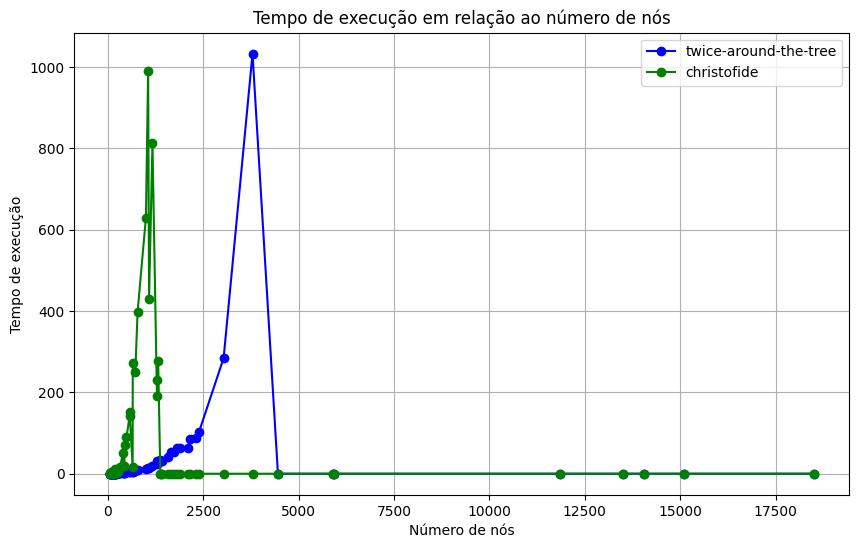

In [65]:
# Plotar gráfico
plt.figure(figsize=(10, 6))

plt.plot(df_atat['Nós'], df_atat['tempo execução'], marker='o', color='blue', label='twice-around-the-tree')
plt.plot(df_achr['Nós'], df_achr['tempo execução'], marker='o', color='green', label='christofide')

plt.title("Tempo de execução em relação ao número de nós")
plt.xlabel("Número de nós")
plt.ylabel("Tempo de execução")
plt.legend()
plt.grid(True)
plt.show()